GBIF.org (26 October 2024) GBIF Occurrence Download  https://doi.org/10.15468/dl.gu5t27

### Imports

In [21]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran
import pandas as pd

In [2]:
original_data = pd.read_csv('kenya_birds.csv', sep='\t')
original_data.head()

/var/folders/cc/h352fz_d24n9tjfbnmrxstbh0000gn/T/ipykernel_7142/1727274082.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  original_data = pd.read_csv('kenya_birds.csv', sep='\t')


gbifID                            datasetKey   
0  1986821111  d1e8a7af-097a-4ca8-aa91-62d3ff834711  \
1  1986821110  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
2  1986821109  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
3  1986821108  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
4  1986821107  d1e8a7af-097a-4ca8-aa91-62d3ff834711   

                           occurrenceID   kingdom    phylum class   
0  d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b  Animalia  Chordata  Aves  \
1  d12a2b54-f12a-40a7-bfb5-90b4998af7d3  Animalia  Chordata  Aves   
2  ff92601a-f8b9-4db0-90a1-e4d0b233ace0  Animalia  Chordata  Aves   
3  a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342  Animalia  Chordata  Aves   
4  215c7fe0-9e39-4497-86b5-87532c478ef8  Animalia  Chordata  Aves   

           order        family      genus                 species  ...   
0  Passeriformes  Zosteropidae  Zosterops      Zosterops silvanus  ...  \
1  Passeriformes  Zosteropidae  Zosterops  Zosterops senegalensis  ...   
2  Passeriformes  Zosteropidae  Zosterops  Zosterops senegalensis  ...   
3  Passeriformes  Zosteropidae  Zosterops      Zosterops silvanus  ...   
4  Passeriformes  Zosteropidae  Zosterops      Zosterops silvanus  ...   

  identifiedBy dateIdentified    license rightsHolder  recordedBy typeStatus   
0          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN  \
1          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
2          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
3          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
4          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   

   establishmentMeans           lastInterpreted mediaType   
0                 NaN  2024-03-21T12:54:52.894Z       NaN  \
1                 NaN  2024-03-21T12:54:54.972Z       NaN   
2                 NaN  2024-03-21T12:54:57.153Z       NaN   
3                 NaN  2024-03-21T12:55:11.136Z       NaN   
4                 NaN  2024-03-21T12:54:51.116Z       NaN   

                                               issue  
0  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
1  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
2  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
3  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
4  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  

[5 rows x 50 columns]

### Data pre-processing

First, let's remove rows that are irrelevant for our analysis:

In [3]:
df1 = original_data.drop(['gbifID', 'datasetKey', 'occurrenceID', 'verbatimScientificNameAuthorship', 'countryCode', 'publishingOrgKey', 'institutionCode', 'collectionCode', 
                 'catalogNumber', 'recordNumber', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'issue'], axis=1)

df1.head()

kingdom    phylum class          order        family      genus   
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops  \
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species infraspecificEpithet taxonRank   
0      Zosterops silvanus                  NaN   SPECIES  \
1  Zosterops senegalensis                  NaN   SPECIES   
2  Zosterops senegalensis                  NaN   SPECIES   
3      Zosterops silvanus                  NaN   SPECIES   
4      Zosterops silvanus                  NaN   SPECIES   

                                    scientificName  ...   eventDate  day   
0  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...  2017-11-09    9  \
1           Zosterops senegalensis Bonaparte, 1850  ...  2017-06-01    1   
2           Zosterops senegalensis Bonaparte, 1850  ...  2017-06-01    1   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...  2017-10-06    6   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...  2017-10-06    6   

   month  year  taxonKey  speciesKey      basisOfRecord  identifiedBy   
0     11  2017   6100772   6100772.0  HUMAN_OBSERVATION           NaN  \
1      6  2017   2489344   2489344.0  HUMAN_OBSERVATION           NaN   
2      6  2017   2489344   2489344.0  HUMAN_OBSERVATION           NaN   
3     10  2017   6100772   6100772.0  HUMAN_OBSERVATION           NaN   
4     10  2017   6100772   6100772.0  HUMAN_OBSERVATION           NaN   

   dateIdentified  mediaType  
0             NaN        NaN  
1             NaN        NaN  
2             NaN        NaN  
3             NaN        NaN  
4             NaN        NaN  

[5 rows x 33 columns]

Now, let's remove columns that are a form of duplicate of other columns:

In [4]:
df2 = df1.drop(['day', 'month', 'year', 'dateIdentified' # the date is contained in 'eventDate'
                ], axis=1)

df2.head()

kingdom    phylum class          order        family      genus   
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops  \
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species infraspecificEpithet taxonRank   
0      Zosterops silvanus                  NaN   SPECIES  \
1  Zosterops senegalensis                  NaN   SPECIES   
2  Zosterops senegalensis                  NaN   SPECIES   
3      Zosterops silvanus                  NaN   SPECIES   
4      Zosterops silvanus                  NaN   SPECIES   

                                    scientificName  ... elevation   
0  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...       NaN  \
1           Zosterops senegalensis Bonaparte, 1850  ...       NaN   
2           Zosterops senegalensis Bonaparte, 1850  ...       NaN   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...       NaN   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...       NaN   

   elevationAccuracy  depth depthAccuracy   eventDate  taxonKey  speciesKey   
0                NaN    NaN           NaN  2017-11-09   6100772   6100772.0  \
1                NaN    NaN           NaN  2017-06-01   2489344   2489344.0   
2                NaN    NaN           NaN  2017-06-01   2489344   2489344.0   
3                NaN    NaN           NaN  2017-10-06   6100772   6100772.0   
4                NaN    NaN           NaN  2017-10-06   6100772   6100772.0   

       basisOfRecord  identifiedBy  mediaType  
0  HUMAN_OBSERVATION           NaN        NaN  
1  HUMAN_OBSERVATION           NaN        NaN  
2  HUMAN_OBSERVATION           NaN        NaN  
3  HUMAN_OBSERVATION           NaN        NaN  
4  HUMAN_OBSERVATION           NaN        NaN  

[5 rows x 29 columns]

Next, we see that a couple of columns seem to take the same values for each row, let's check that:

In [5]:
unique_occurrence_status = df2['occurrenceStatus'].unique()
unique_basis_of_record = df2['basisOfRecord'].unique()

print("Unique values in 'occurrenceStatus':")
print(unique_occurrence_status)

print("\nUnique values in 'basisOfRecord':")
print(unique_basis_of_record)

Unique values in 'occurrenceStatus':
['PRESENT']

Unique values in 'basisOfRecord':
['HUMAN_OBSERVATION']


Let's remove those columns as well since they take the same value for all rows:

In [6]:
df = df2.drop(['occurrenceStatus', 'basisOfRecord'], axis=1)

df.head()

kingdom    phylum class          order        family      genus   
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops  \
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species infraspecificEpithet taxonRank   
0      Zosterops silvanus                  NaN   SPECIES  \
1  Zosterops senegalensis                  NaN   SPECIES   
2  Zosterops senegalensis                  NaN   SPECIES   
3      Zosterops silvanus                  NaN   SPECIES   
4      Zosterops silvanus                  NaN   SPECIES   

                                    scientificName  ... coordinatePrecision   
0  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...                 NaN  \
1           Zosterops senegalensis Bonaparte, 1850  ...                 NaN   
2           Zosterops senegalensis Bonaparte, 1850  ...                 NaN   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...                 NaN   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...                 NaN   

   elevation  elevationAccuracy  depth  depthAccuracy   eventDate  taxonKey   
0        NaN                NaN    NaN            NaN  2017-11-09   6100772  \
1        NaN                NaN    NaN            NaN  2017-06-01   2489344   
2        NaN                NaN    NaN            NaN  2017-06-01   2489344   
3        NaN                NaN    NaN            NaN  2017-10-06   6100772   
4        NaN                NaN    NaN            NaN  2017-10-06   6100772   

   speciesKey  identifiedBy  mediaType  
0   6100772.0           NaN        NaN  
1   2489344.0           NaN        NaN  
2   2489344.0           NaN        NaN  
3   6100772.0           NaN        NaN  
4   6100772.0           NaN        NaN  

[5 rows x 27 columns]

Let's check for missing values:

In [7]:
missing_counts = df2.isnull().sum()

total_rows = len(df2)
missing_percentage = (missing_counts / total_rows) * 100

missing_summary = pd.DataFrame({
    'Column Name': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing Percentage': missing_percentage.values
})

print(missing_summary)

                      Column Name  Missing Count  Missing Percentage
0                         kingdom              0            0.000000
1                          phylum              0            0.000000
2                           class              0            0.000000
3                           order              0            0.000000
4                          family              0            0.000000
5                           genus              0            0.000000
6                         species            185            0.206400
7            infraspecificEpithet          89593           99.956489
8                       taxonRank              0            0.000000
9                  scientificName              0            0.000000
10         verbatimScientificName              0            0.000000
11                       locality          89632          100.000000
12                  stateProvince          89632          100.000000
13               occurrenceStatus 

First, let's remove the columns with nearly all, or all values missing:

In [8]:
df3 = df2.drop(['infraspecificEpithet', 'locality', 'stateProvince', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy',
                'depth', 'depthAccuracy', 'identifiedBy', 'mediaType'], axis=1)

df3.head()

kingdom    phylum class          order        family      genus   
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops  \
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species taxonRank   
0      Zosterops silvanus   SPECIES  \
1  Zosterops senegalensis   SPECIES   
2  Zosterops senegalensis   SPECIES   
3      Zosterops silvanus   SPECIES   
4      Zosterops silvanus   SPECIES   

                                    scientificName  verbatimScientificName   
0  Zosterops silvanus J.L.Peters & Loveridge, 1935      Zosterops silvanus  \
1           Zosterops senegalensis Bonaparte, 1850  Zosterops senegalensis   
2           Zosterops senegalensis Bonaparte, 1850  Zosterops senegalensis   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935      Zosterops silvanus   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935      Zosterops silvanus   

  occurrenceStatus  individualCount  decimalLatitude  decimalLongitude   
0          PRESENT              1.0        -3.432285         38.341012  \
1          PRESENT              1.0         0.206000         34.884667   
2          PRESENT              4.0        -0.558500         36.523667   
3          PRESENT              1.0        -3.399601         38.329516   
4          PRESENT              1.0        -3.380438         38.353286   

    eventDate  taxonKey  speciesKey      basisOfRecord  
0  2017-11-09   6100772   6100772.0  HUMAN_OBSERVATION  
1  2017-06-01   2489344   2489344.0  HUMAN_OBSERVATION  
2  2017-06-01   2489344   2489344.0  HUMAN_OBSERVATION  
3  2017-10-06   6100772   6100772.0  HUMAN_OBSERVATION  
4  2017-10-06   6100772   6100772.0  HUMAN_OBSERVATION

In [9]:
df.shape

(89632, 27)

Finally, let's handle the remaining missing values.

- For column 'individualCount', we will replace the missing values by the median of the column. It is a more accurate replacement than the mean due to some extreme outliers, especially since both quartiles are equal to 1.
- For columns 'species' and 'speciesKey', we will delete the rows with missing values, as there is only a very tiny percentage of those and we will still have a very rich data set afterwards.

In [10]:
df['individualCount'].describe()

count    89552.000000
mean         2.081472
std         34.485674
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       7000.000000
Name: individualCount, dtype: float64

In [11]:
df['individualCount'].fillna(df['individualCount'].median(), inplace=True)
df.dropna(subset=['species', 'speciesKey'], inplace=True)

In [12]:
upd_missing_counts = df.isnull().sum()

upd_total_rows = len(df)
upd_missing_percentage = (upd_missing_counts / upd_total_rows) * 100

upd_missing_summary = pd.DataFrame({
    'Column Name': upd_missing_counts.index,
    'Missing Count': upd_missing_counts.values,
    'Missing Percentage': upd_missing_percentage.values
})

print(upd_missing_summary)

                      Column Name  Missing Count  Missing Percentage
0                         kingdom              0            0.000000
1                          phylum              0            0.000000
2                           class              0            0.000000
3                           order              0            0.000000
4                          family              0            0.000000
5                           genus              0            0.000000
6                         species              0            0.000000
7            infraspecificEpithet          89408           99.956399
8                       taxonRank              0            0.000000
9                  scientificName              0            0.000000
10         verbatimScientificName              0            0.000000
11                       locality          89447          100.000000
12                  stateProvince          89447          100.000000
13                individualCount 

### Question 1

First, let's check in terms of numbers the sightings of each individual order:

In [13]:
order_counts = df['order'].value_counts()
order_counts_df = order_counts.reset_index()
order_counts_df.columns = ['order', 'count'] 

total_count = order_counts_df['count'].sum()
order_counts_df['percentage'] = (order_counts_df['count'] / total_count) * 100

print(order_counts_df)

                  order  count  percentage
0         Passeriformes  49770   55.641888
1        Pelecaniformes   5545    6.199202
2       Accipitriformes   5439    6.080696
3         Columbiformes   4943    5.526178
4       Charadriiformes   3958    4.424967
5         Coraciiformes   3111    3.478037
6            Piciformes   2845    3.180654
7        Bucerotiformes   1752    1.958702
8           Coliiformes   1588    1.775353
9          Cuculiformes   1426    1.594240
10          Apodiformes   1361    1.521571
11         Anseriformes   1261    1.409773
12          Galliformes   1169    1.306919
13        Ciconiiformes   1097    1.226425
14           Gruiformes    853    0.953637
15      Musophagiformes    741    0.828424
16           Suliformes    485    0.542221
17        Falconiformes    320    0.357754
18          Otidiformes    318    0.355518
19       Psittaciformes    312    0.348810
20         Strigiformes    223    0.249310
21     Podicipediformes    211    0.235894
22     Capr

Let's plot:

In [14]:
# Get unique values from the 'order' column
unique_orders = df['order'].unique()

# Create a color map
colors = plt.cm.get_cmap('tab20b', len(unique_orders)) 

# Map unique values to colors
order_color_map = {order: colors(i) for i, order in enumerate(unique_orders)}

/var/folders/cc/h352fz_d24n9tjfbnmrxstbh0000gn/T/ipykernel_7142/39467370.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20b', len(unique_orders))


/var/folders/cc/h352fz_d24n9tjfbnmrxstbh0000gn/T/ipykernel_8602/2697733632.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20b', len(unique_orders))


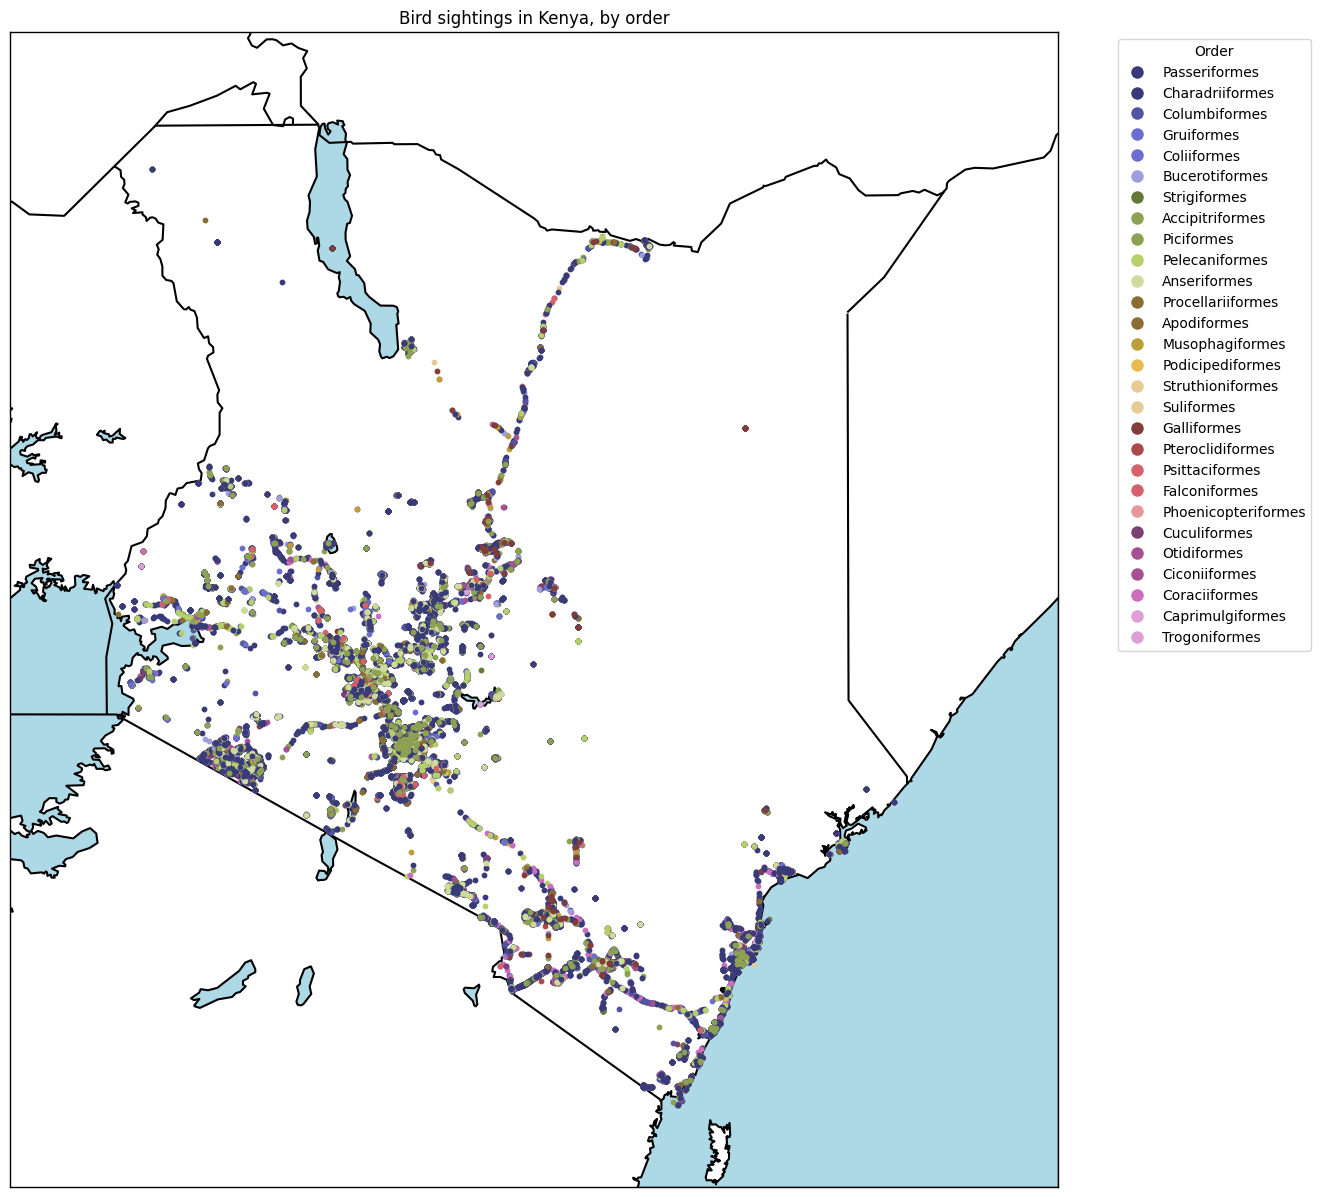

In [30]:
# df_subset = df.head(1000)

plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,  # Latitude limits
            llcrnrlon=33, urcrnrlon=43,  # Longitude limits
            resolution='i')

m.drawmapboundary(fill_color='lightblue')  # Ocean color
m.fillcontinents(color='white', lake_color='lightblue')  # Land color
m.drawcountries(linewidth=1.5, color='black')  # Country boundaries
m.drawcoastlines(linewidth=1.5, color='black')  # Coastline

# Plot each point with the corresponding color
for index, row in df.iterrows():
    x, y = m(row['decimalLongitude'], row['decimalLatitude'])
    plt.scatter(x, y, marker='o', color=order_color_map[row['order']], zorder=5, label=row['order'], s=10)

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=order_color_map[order], markersize=10) for order in unique_orders]
plt.legend(handles, unique_orders, title='Order', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bird sightings in Kenya, by order')
plt.show()

Interesting pattern going north, turns out it's one of Kenya's national highways, the A2. The other sightings following a line are other major roads. It makes sense since probably much more people take those roads than the smaller ones in the countryside, hence there is more people who could spot birds. Also, these roads are much easier to access than any small road.

There are a lot if sightings by the coast, which does make sense since birds tend to cluster by coasts to look for food.

There is an interesting cluster at the western part of the south border, which turns out to be the Maasai Mara National Reserve.

Apart from that, most sightings were noted at the heart of the country, where most people live (Nairobi, Nakuru, Nyeri), as well as a very tall mountain Kirinyaga, which could potentially be a touristic spot.

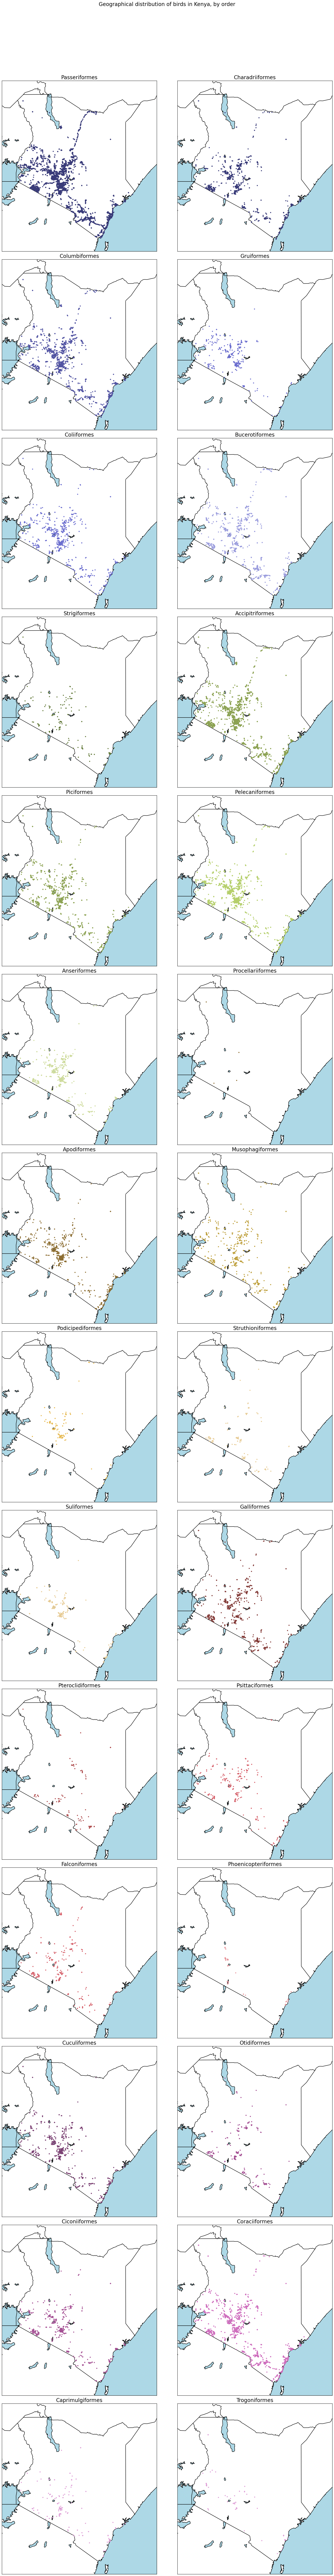

In [44]:
fig, axs = plt.subplots(nrows=14, ncols=2, figsize=(20, 140))
axs = axs.flatten()

# Loop through each unique order and create a map
for i, order in enumerate(unique_orders):
    df_order = df[df['order'] == order] #.head(100) Limit to the first 100 entries for now

    # Create Basemap for the current subplot
    m = Basemap(projection='merc',
                llcrnrlat=-5.5, urcrnrlat=5.5,  # Latitude limits
                llcrnrlon=33, urcrnrlon=43,  # Longitude limits
                resolution='i', ax=axs[i])

    m.drawmapboundary(fill_color='lightblue')  # Ocean color
    m.fillcontinents(color='white', lake_color='lightblue')  # Land color
    m.drawcountries(linewidth=1.5, color='black')  # Country boundaries
    m.drawcoastlines(linewidth=1.5, color='black')  # Coastline

    # Plot the points for the current order using the inherited color mapping
    if not df_order.empty:  # Check if there's data to plot
        x, y = m(df_order['decimalLongitude'].values, df_order['decimalLatitude'].values)
        m.scatter(x, y, marker='o', color=order_color_map[order], zorder=5, s=10)

    # Set the title for the subplot
    axs[i].set_title(order, fontsize=20)

plt.tight_layout()
plt.suptitle('Geographical distribution of birds in Kenya, by order', fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

Let's now compute Moran's I to look for clusters:

In [25]:
# Step 1: Encode the 'order' column as integers
df['order_encoded'] = pd.factorize(df['order'])[0] + 1

# Step 2: Create a GeoDataFrame from your DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']))

# Step 3: Loop over different k values and calculate Moran's I for each
results = {}  # Dictionary to store results for each k

for k in [3, 5, 7, 10]:  # List of k-values to test
    # Create spatial weights based on k-nearest neighbors
    coords = list(zip(df['decimalLatitude'], df['decimalLongitude']))
    w = KNN.from_array(coords, k=k)
    
    # Calculate Moran's I
    moran = Moran(df['order_encoded'], w)
    
    # Store the Moran's I and p-value for this k
    results[k] = {'Morans I': moran.I, 'p-value': moran.p_sim}

# Step 4: Print out the results for each k
for k, result in results.items():
    print(f"For k={k}: Moran's I = {result['Morans I']}, p-value = {result['p-value']}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4190 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 1535 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 798 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 447 disconnected comp

For k=3: Moran's I = 0.08096781459266722, p-value = 0.001
For k=5: Moran's I = 0.0742619392740942, p-value = 0.001
For k=7: Moran's I = 0.06814392344015557, p-value = 0.001
For k=10: Moran's I = 0.06450292745925464, p-value = 0.001


The Moran’s I value is positive in all cases, meaning there is positive spatial autocorrelation in the data (similar values are clustered). As $k$ increases, the Moran's I slightly decreases, suggesting that as the neighborhood size increases, the spatial clustering is slightly less pronounced. This could be because the larger neighborhood size is considering more distant points, which might weaken the autocorrelation signal.

Regarding the p-values, it is 0.001 for each $k$, which is very small. This means that the spatial autocorrelation is highly significant, and it is unlikely to be due to random chance.

Now, let's try to cluster these points:

/var/folders/cc/h352fz_d24n9tjfbnmrxstbh0000gn/T/ipykernel_2367/4222356339.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # color map for clusters


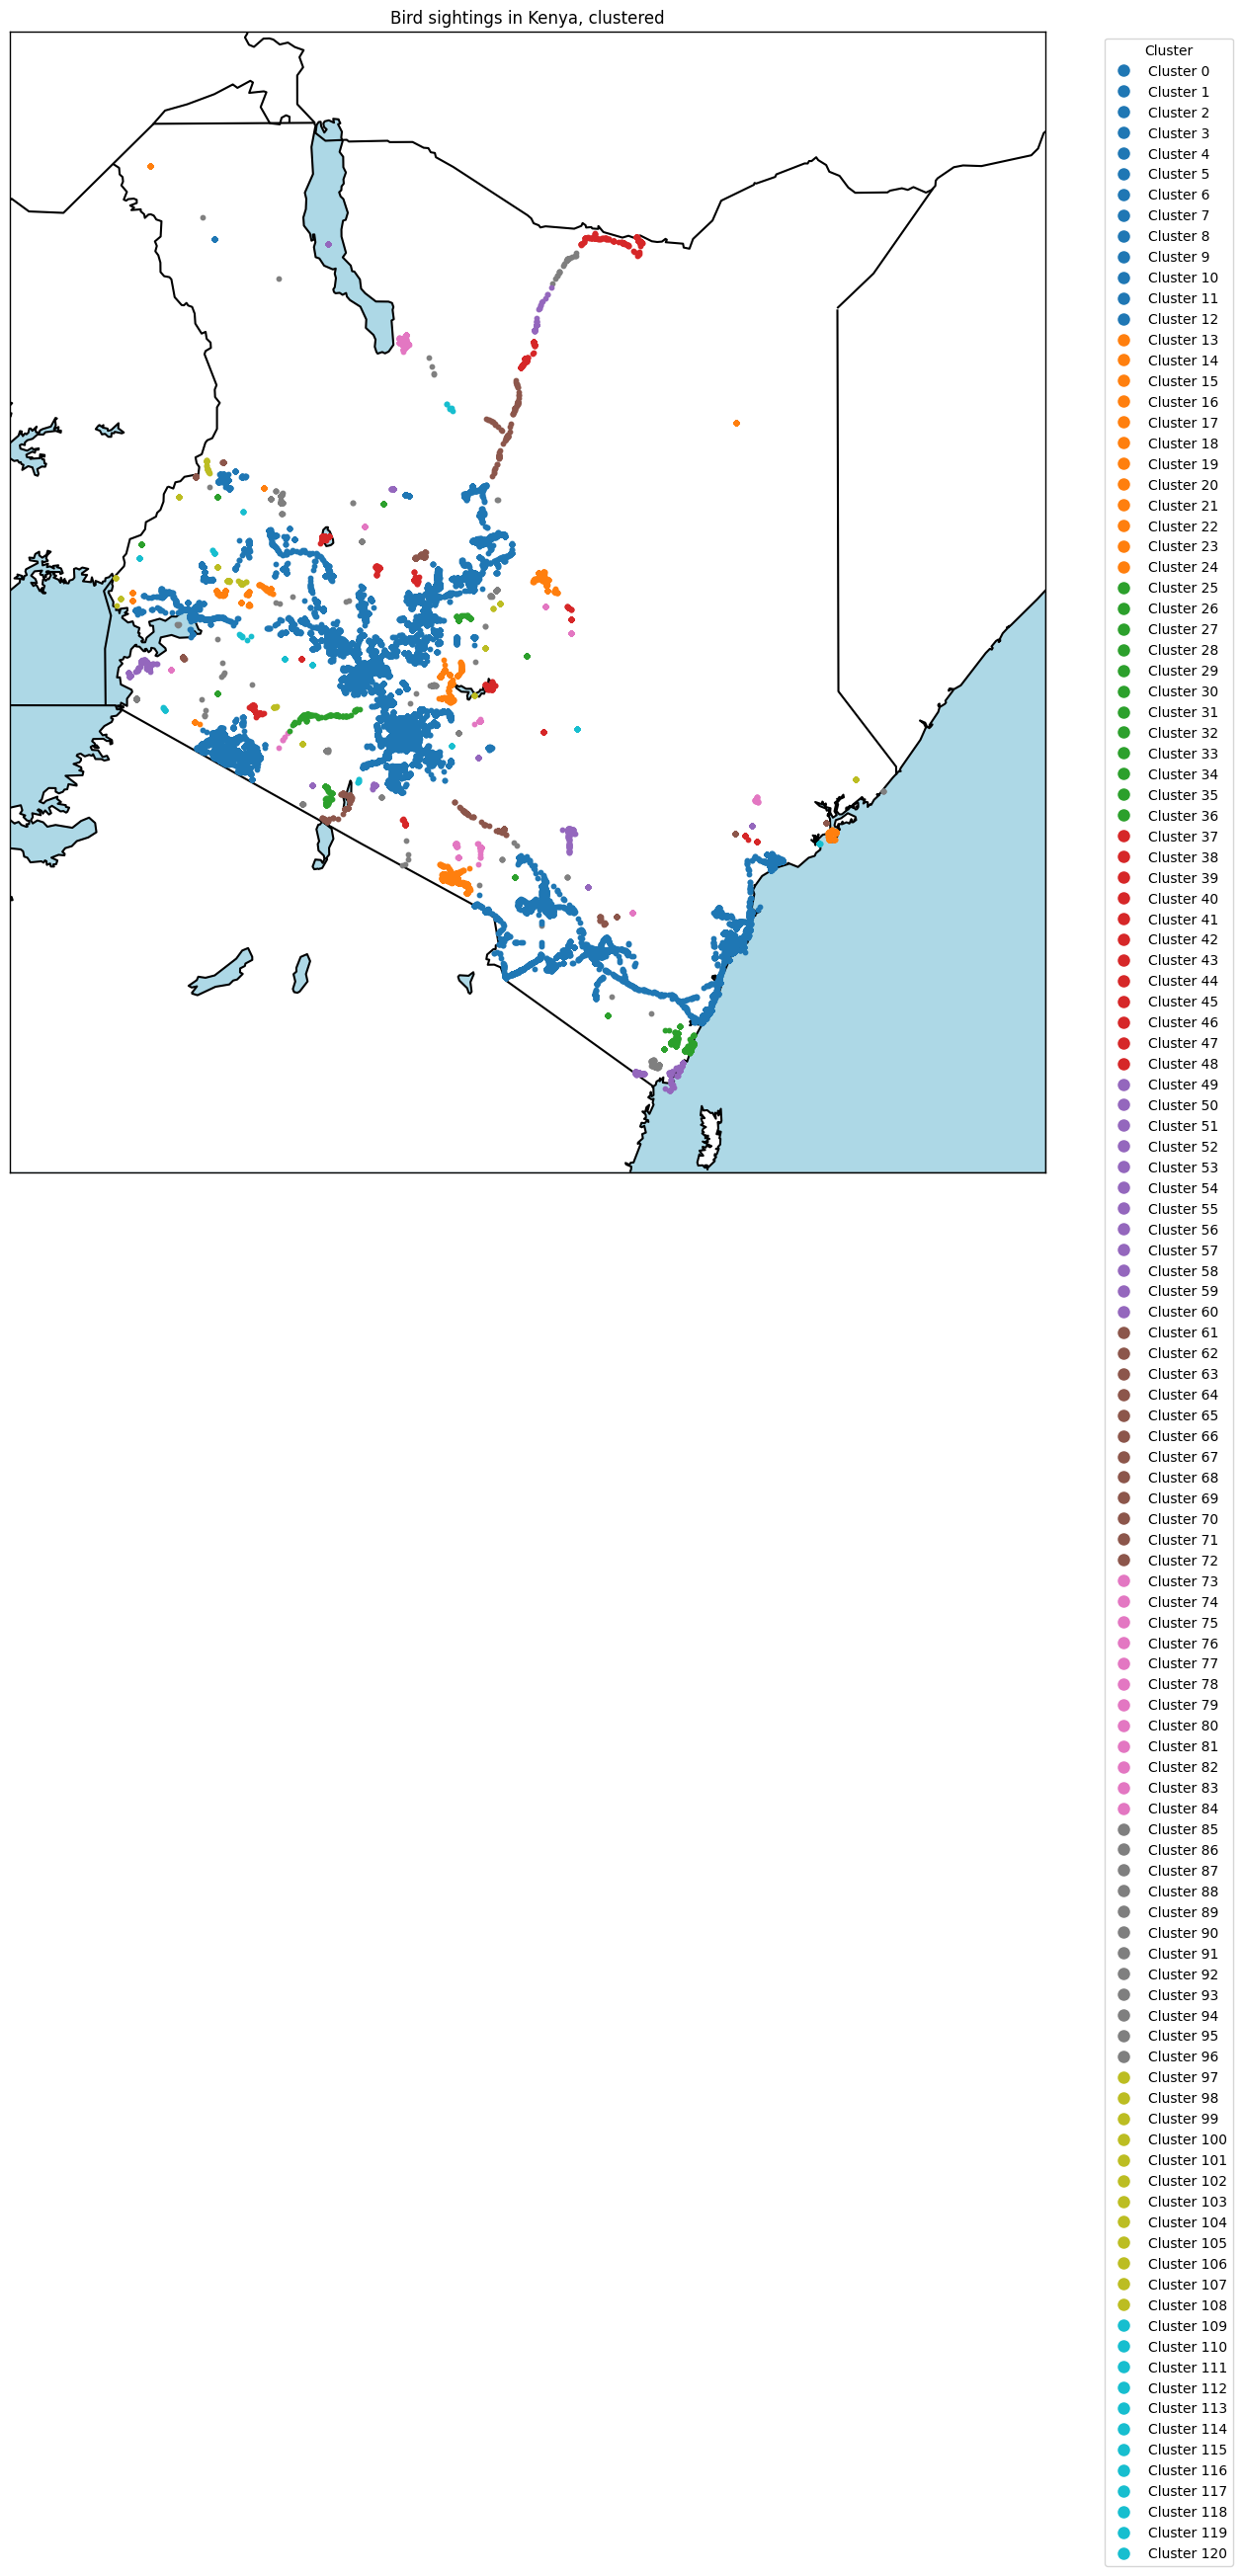

In [ ]:
coordinates = np.array([m(row['decimalLongitude'], row['decimalLatitude']) for _, row in df.iterrows()])

# Apply DBSCAN
db = DBSCAN(eps=10000, min_samples=5)  # eps is in map projection units; adjust as needed
labels = db.fit_predict(coordinates)

# Add cluster labels to the DataFrame
df['cluster'] = labels

# Plot
plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,
            llcrnrlon=33, urcrnrlon=43,
            resolution='i')

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='white', lake_color='lightblue')
m.drawcountries(linewidth=1.5, color='black')
m.drawcoastlines(linewidth=1.5, color='black')

# Plot each point, colored by cluster
unique_clusters = df['cluster'].unique()
cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # color map for clusters

for index, row in df.iterrows():
    x, y = m(row['decimalLongitude'], row['decimalLatitude'])
    cluster_label = row['cluster']
    color = 'gray' if cluster_label == -1 else cluster_colors(cluster_label)  # Gray for noise
    plt.scatter(x, y, marker='o', color=color, zorder=5, s=10)

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors(i), markersize=10) 
           for i in range(len(unique_clusters)) if i != -1]
plt.legend(handles, [f'Cluster {i}' for i in unique_clusters if i != -1], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bird sightings in Kenya, clustered')
plt.show()

/var/folders/cc/h352fz_d24n9tjfbnmrxstbh0000gn/T/ipykernel_7142/4205554325.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # color map for clusters


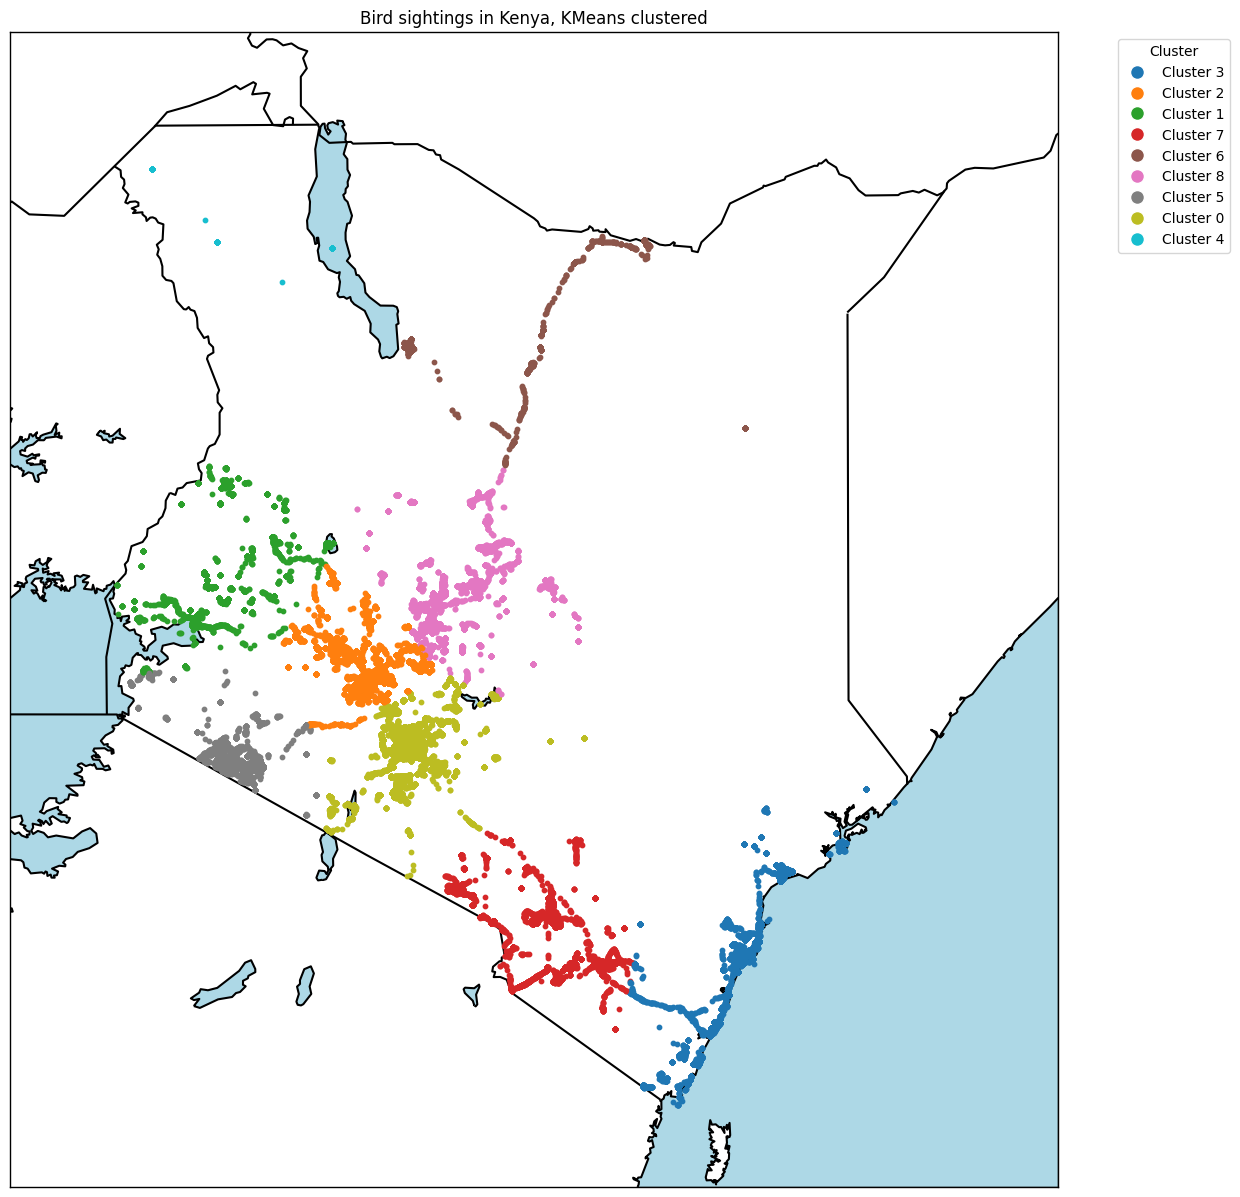

In [17]:
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,  # Latitude limits
            llcrnrlon=33, urcrnrlon=43,  # Longitude limits
            resolution='i')

coordinates = np.array([m(row['decimalLongitude'], row['decimalLatitude']) for _, row in df.iterrows()])

kmeans = KMeans(n_clusters=9, random_state=0)
df['cluster'] = kmeans.fit_predict(coordinates)

# Plot
plt.figure(figsize=(20, 15))

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='white', lake_color='lightblue')
m.drawcountries(linewidth=1.5, color='black')
m.drawcoastlines(linewidth=1.5, color='black')

# Plot each point, colored by cluster
unique_clusters = df['cluster'].unique()
cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # color map for clusters

for index, row in df.iterrows():
    x, y = m(row['decimalLongitude'], row['decimalLatitude'])
    cluster_label = row['cluster']
    color = cluster_colors(cluster_label)
    plt.scatter(x, y, marker='o', color=color, zorder=5, s=10)

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors(i), markersize=10) 
           for i in range(len(unique_clusters))]
plt.legend(handles, [f'Cluster {i}' for i in unique_clusters], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bird sightings in Kenya, KMeans clustered')
plt.show()

### Question 2

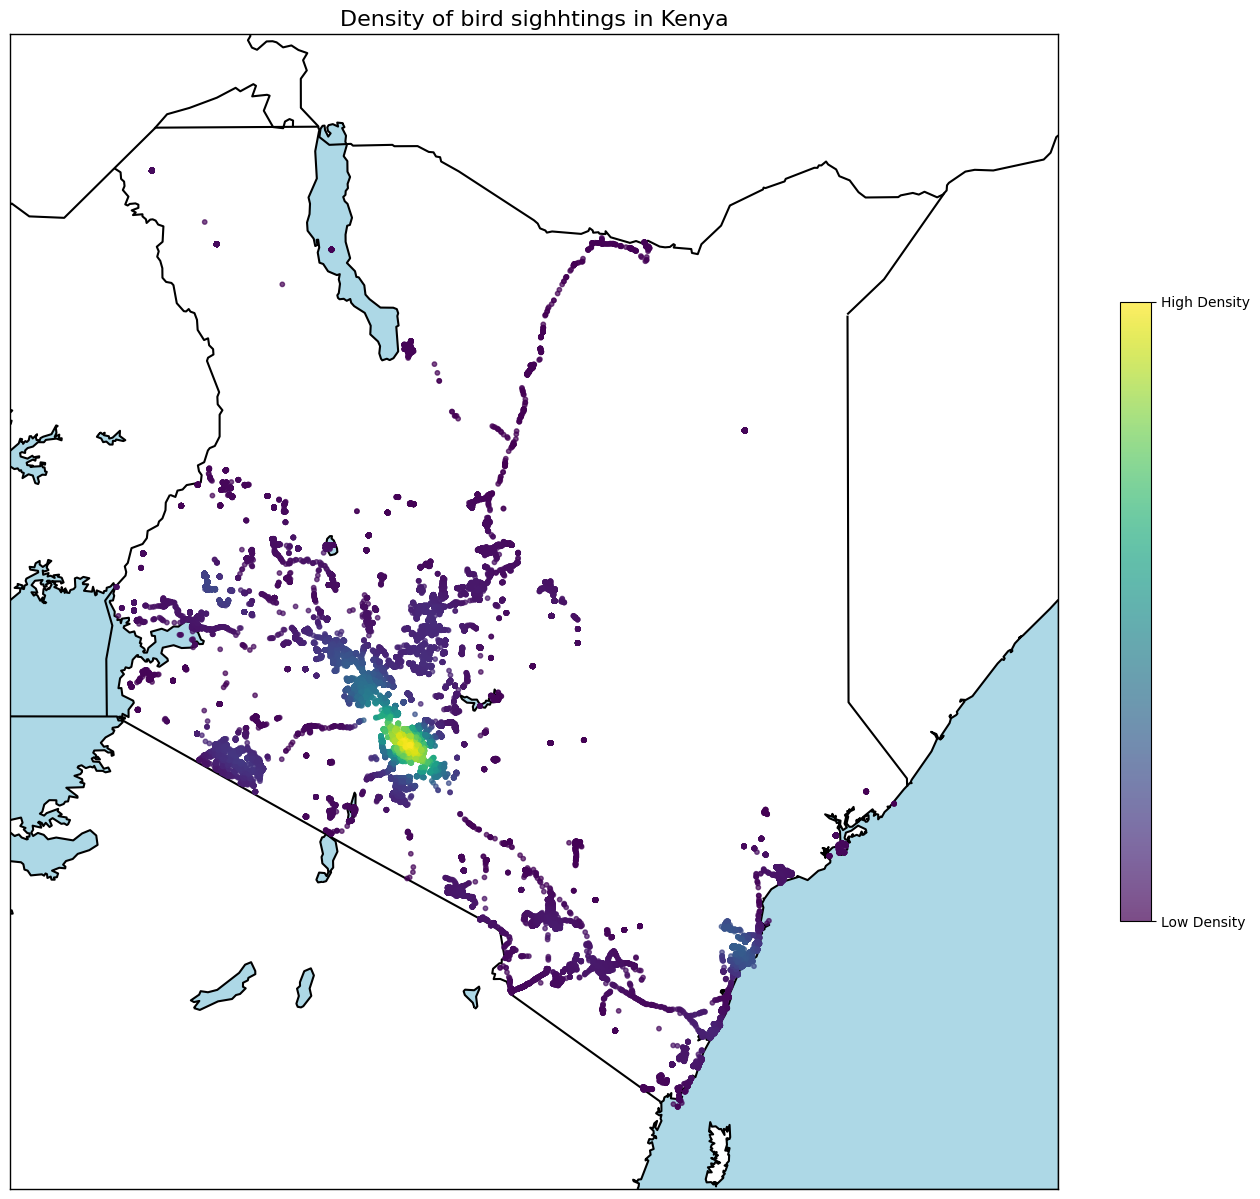

In [48]:
plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,  # Latitude limits
            llcrnrlon=33, urcrnrlon=43,  # Longitude limits
            resolution='i')

m.drawmapboundary(fill_color='lightblue')  # Ocean color
m.fillcontinents(color='white', lake_color='lightblue')  # Land color
m.drawcountries(linewidth=1.5, color='black')  # Country boundaries
m.drawcoastlines(linewidth=1.5, color='black')  # Coastline

# Extract the latitude and longitude
latitudes = df['decimalLatitude'].values
longitudes = df['decimalLongitude'].values

# Create a grid for the density estimation
lon_grid = np.linspace(33, 43, 100)  # Longitude grid
lat_grid = np.linspace(-5.5, 5.5, 100)  # Latitude grid
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Flatten the grid to evaluate the density
positions = np.vstack([lon_mesh.ravel(), lat_mesh.ravel()])
values = np.vstack([longitudes, latitudes])

# Create a Gaussian KDE
kde = gaussian_kde(values)

# Evaluate the density on the grid
density = kde(positions).reshape(lon_mesh.shape)

# Normalize the density for colormap
density_normalized = (density - density.min()) / (density.max() - density.min())

# Create a colormap for the density
cmap = plt.get_cmap('viridis')

# Calculate the density value for each point and map to colors
point_density = kde(np.vstack([longitudes, latitudes]))
colors = cmap((point_density - point_density.min()) / (point_density.max() - point_density.min()))

# Plot the points with the corresponding colors
x_points, y_points = m(longitudes, latitudes)
scatter = m.scatter(x_points, y_points, marker='o', color=colors, zorder=5, alpha=0.7, s=10)

cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.02, pad=0.04)

cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low Density', 'High Density'])

plt.title('Density of bird sighhtings in Kenya', fontsize=16)
plt.show()

let's consider individualCount as weight of each sighting so that a higher count contributes more heavily to the density

now, that column has 80 missing values, so let's first handle those:

In [43]:
df['individualCount'].describe()

count    89552.000000
mean         2.081472
std         34.485674
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       7000.000000
Name: individualCount, dtype: float64

we see that apart from some outliers, most counts are quite small and the median is 1. Let's replace all missing values with the median:

In [44]:
df['individualCount'].fillna(df['individualCount'].median(), inplace=True)

In [46]:
df['individualCount'].isnull().sum()

0

all good to proceed

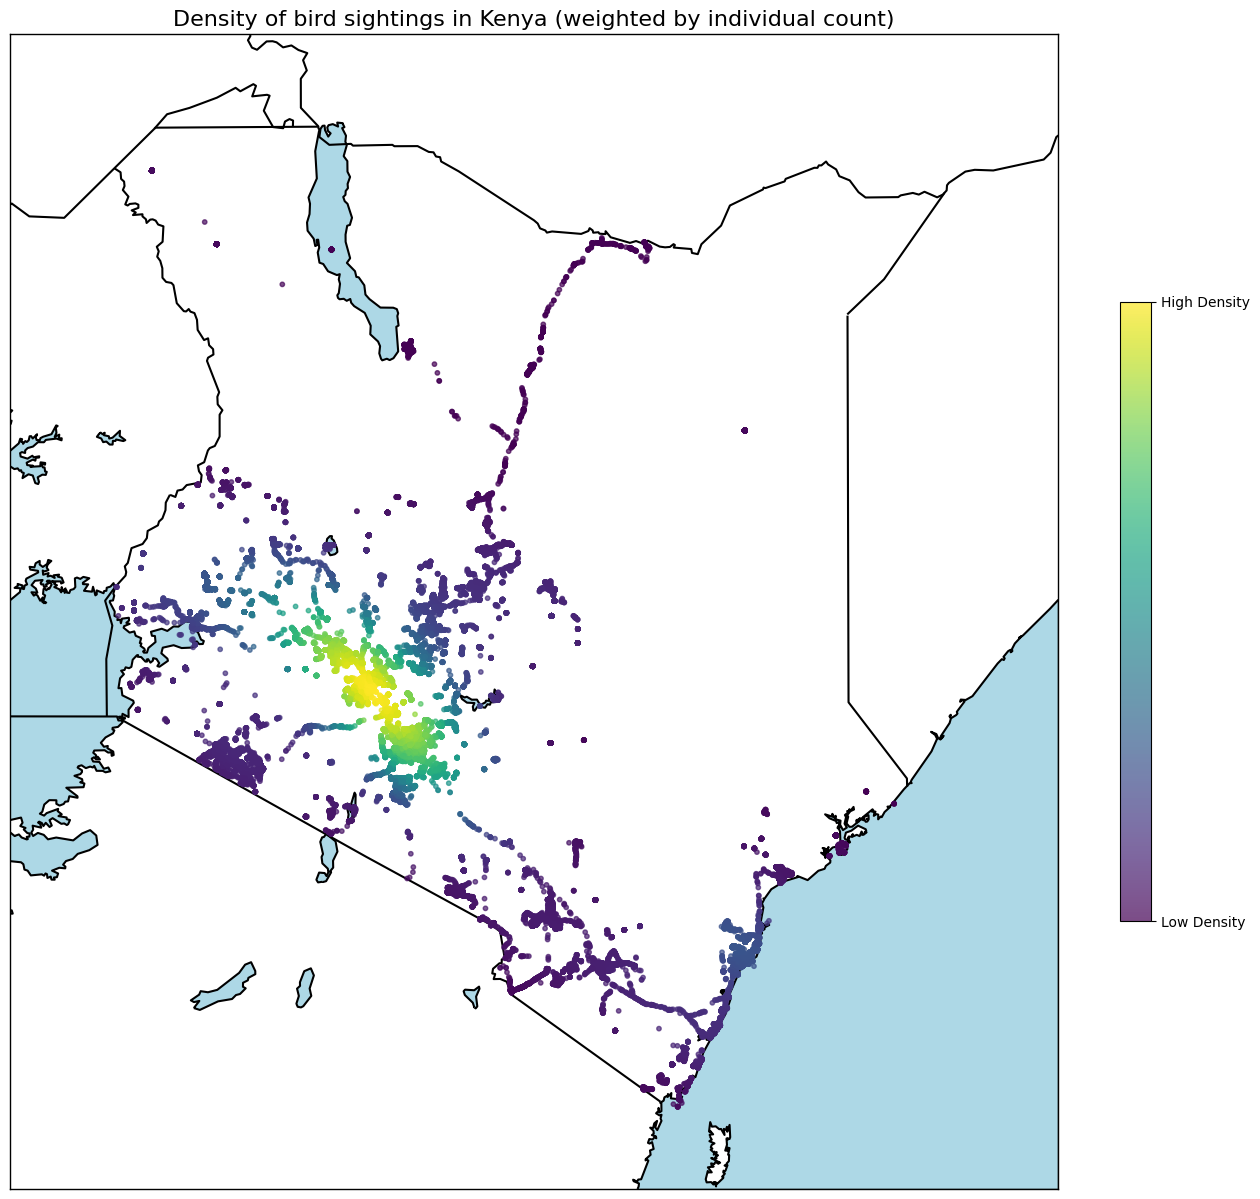

In [47]:
plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,  # Latitude limits
            llcrnrlon=33, urcrnrlon=43,  # Longitude limits
            resolution='i')

m.drawmapboundary(fill_color='lightblue')  # Ocean color
m.fillcontinents(color='white', lake_color='lightblue')  # Land color
m.drawcountries(linewidth=1.5, color='black')  # Country boundaries
m.drawcoastlines(linewidth=1.5, color='black')  # Coastline

# Extract the latitude, longitude, and individualCount columns
latitudes = df['decimalLatitude'].values
longitudes = df['decimalLongitude'].values
individual_counts = df['individualCount'].values  # Weights for KDE

# Create a grid for the density estimation
lon_grid = np.linspace(33, 43, 100)  # Longitude grid
lat_grid = np.linspace(-5.5, 5.5, 100)  # Latitude grid
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Flatten the grid to evaluate the density
positions = np.vstack([lon_mesh.ravel(), lat_mesh.ravel()])
values = np.vstack([longitudes, latitudes])

# Create a Gaussian KDE with weights
kde = gaussian_kde(values, weights=individual_counts)

# Evaluate the density on the grid
density = kde(positions).reshape(lon_mesh.shape)

# Normalize the density for colormap
density_normalized = (density - density.min()) / (density.max() - density.min())

# Create a colormap for the density
cmap = plt.get_cmap('viridis')

# Calculate the density value for each point and map to colors
point_density = kde(np.vstack([longitudes, latitudes]))
colors = cmap((point_density - point_density.min()) / (point_density.max() - point_density.min()))

# Plot the points with the corresponding colors
x_points, y_points = m(longitudes, latitudes)
scatter = m.scatter(x_points, y_points, marker='o', color=colors, zorder=5, alpha=0.7, s=10)

# Add colorbar and set labels
cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low Density', 'High Density'])

plt.title('Density of bird sightings in Kenya (weighted by individual count)', fontsize=16)
plt.show()

yep big difference